# Building LeNet from scratch with Pytorch

As proposed in the chapter 3 of the book, here is the code to implement the LeNet-5 architecture from scratch with PyTorch.

This notebook uses the requirements specified in the `requirements.txt` file.

## About LeNet-5

LeNet-5, most known as LeNet, is a convolutional neural network designed by Yann LeCun et al. in 1998 for the recognition of handwritten digits. It was the first convolutional network for handwritten character recognition and was used later for many other recognition tasks, such as facial recognition and traffic sign recognition.
5 in LeNet-5 refers to the number of layers in the network. The architecture of the network is shown in the following figure:

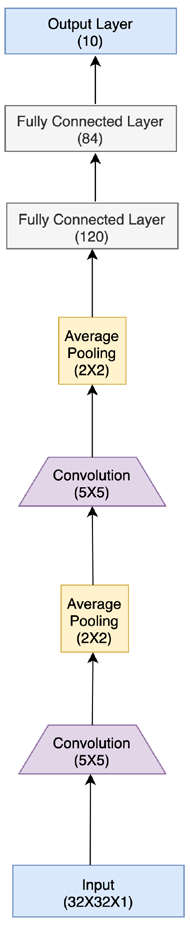

There are two convolutional layers with a kernel size of 5, and three fully connected layers. The network counts roughly 60K parameters. Convolutional layers exploit the spatial correlation among neighboring pixels. In consequence, LeNet demonstrated rotation, translation and scale invariance. It also shown robustness against distortion.

## Developing LeNet with pytorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
 
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

torch.manual_seed(55)

### Defining the model

In [2]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # 3 input image channel, 6 output feature maps and 5x5 conv kernel
        self.cn1 = nn.Conv2d(3, 6, 5)
        # 6 input image channel, 16 output feature maps and 5x5 conv kernel
        self.cn2 = nn.Conv2d(6, 16, 5)
        # fully connected layers of size 120, 84 and 10
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 is the spatial dimension at this layer
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Convolution with 5x5 kernel
        x = F.relu(self.cn1(x))
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(x, (2, 2))
        # Convolution with 5x5 kernel
        x = F.relu(self.cn2(x))
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(x, (2, 2))
        # Flatten spatial and depth dimensions into a single vector
        x = x.view(-1, self.flattened_features(x))
        # Fully connected operations
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def flattened_features(self, x):
        # all except the first (batch) dimension
        size = x.size()[1:]  
        num_feats = 1
        for s in size:
            num_feats *= s
        return num_feats


lenet = LeNet()
print(lenet)

LeNet(
  (cn1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (cn2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Training and validation procedures

In [3]:
def train(net, trainloader, optim, epoch):
    # initialize loss
    loss_total = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # ip refers to the input images, and ground_truth refers to the output classes the images belong to
        ip, ground_truth = data

        # zero the parameter gradients
        optim.zero_grad()

        # forward pass + backward pass + optimization step
        op = net(ip)
        loss = nn.CrossEntropyLoss()(op, ground_truth)
        loss.backward()
        optim.step()

        # update loss
        loss_total += loss.item()
        
        # print loss statistics
        if (i+1) % 1000 == 0:    # print at the interval of 1000 mini-batches
            print('[Epoch number : %d, Mini-batches: %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss_total / 200))
            loss_total = 0.0

In [4]:
# MFT: I renamed all (original) test symbols in validation as I prefer the naming convention of datasets: train, validation, test
def validation(net, validationLoader):
    success = 0
    counter = 0
    with torch.no_grad():
        for data in validationLoader:
            im, ground_truth = data
            op = net(im)
            _, pred = torch.max(op.data, 1)
            counter += ground_truth.size(0)
            success += (pred == ground_truth).sum().item()

    print('LeNet accuracy on 10000 images from validation dataset: %d %%' % (
        100 * success / counter))

### Data loaders and Transformation pipelines

We will use the CIFAR10 dataset for expirements.

In [5]:
# The mean and std are kept as 0.5 for normalizing pixel values as the pixel values are originally in the range 0 to 1
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(32, 4),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True, num_workers=1)


validation_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

validationSet = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=validation_transform)
validationLoader = torch.utils.data.DataLoader(validationSet, batch_size=10000, shuffle=False, num_workers=2)


# ordering is important
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:22<00:00, 7560501.75it/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


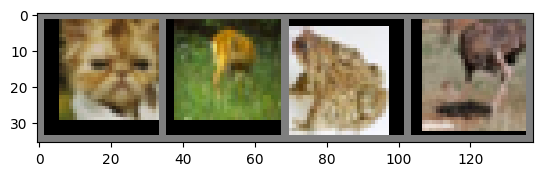

    cat  ||  deer  ||  frog  ||  bird


In [7]:
# define a function that displays an image
def imageshow(image):
    # un-normalize the image
    image = image/2 + 0.5     
    npimage = image.numpy()
    plt.imshow(np.transpose(npimage, (1, 2, 0)))
    plt.show()


# sample images from training set
# dataiter = iter(trainloader)
# images, labels = dataiter.next()
# MFT: corrected a bug on the dataloader iteration
images, labels = next(iter(trainloader))

# display images in a grid
num_images = 4
imageshow(torchvision.utils.make_grid(images[:num_images]))
# print labels
print('    '+'  ||  '.join(classes[labels[j]] for j in range(num_images)))

### Training the network

In [8]:
# define optimizer
optimizer = torch.optim.Adam(lenet.parameters(), lr=0.001)

# training loop over the dataset multiple times
for epoch in range(50):  
    train(lenet, trainloader, optimizer, epoch)
    print()
    validation(lenet, validationLoader)
    print()

print('Finished Training')

[Epoch number : 1, Mini-batches:  1000] loss: 9.752
[Epoch number : 1, Mini-batches:  2000] loss: 8.832
[Epoch number : 1, Mini-batches:  3000] loss: 8.393
[Epoch number : 1, Mini-batches:  4000] loss: 8.139
[Epoch number : 1, Mini-batches:  5000] loss: 7.900
[Epoch number : 1, Mini-batches:  6000] loss: 7.704

LeNet accuracy on 10000 images from validation dataset: 45 %

[Epoch number : 2, Mini-batches:  1000] loss: 7.357
[Epoch number : 2, Mini-batches:  2000] loss: 7.434
[Epoch number : 2, Mini-batches:  3000] loss: 7.392
[Epoch number : 2, Mini-batches:  4000] loss: 7.154
[Epoch number : 2, Mini-batches:  5000] loss: 7.010
[Epoch number : 2, Mini-batches:  6000] loss: 6.968

LeNet accuracy on 10000 images from validation dataset: 51 %

[Epoch number : 3, Mini-batches:  1000] loss: 6.876
[Epoch number : 3, Mini-batches:  2000] loss: 6.738
[Epoch number : 3, Mini-batches:  3000] loss: 6.860
[Epoch number : 3, Mini-batches:  4000] loss: 6.648
[Epoch number : 3, Mini-batches:  5000] lo

We save the model into a file

In [9]:
model_path = './cifar_model.pth'
torch.save(lenet.state_dict(), model_path)

In [10]:
images[:4].shape

torch.Size([4, 3, 32, 32])

Testing the model saved on a input image.

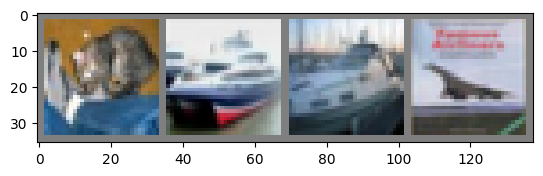

Label:         cat  ship  ship plane
Prediction:   bird  ship  ship plane


In [12]:
# load test dataset images
# d_iter = iter(validationLoader)
# im, ground_truth = d_iter.next()
# MFT: corrected a bug
im, ground_truth = next(iter(validationLoader))

# print images and ground truth
imageshow(torchvision.utils.make_grid(im[:4]))
print('Label:      ', ' '.join('%5s' % classes[ground_truth[j]] for j in range(4)))

# load model
lenet_cached = LeNet()
lenet_cached.load_state_dict(torch.load(model_path))

# model inference
op = lenet_cached(im)

# print predictions
_, pred = torch.max(op, 1)

print('Prediction: ', ' '.join('%5s' % classes[pred[j]] for j in range(4)))

Assessing the accuracy on the validation dataset. MFT: it would be even better to do it on a never-seen dataset (what we call test set), but for this the dataset needs to be split in three, not in two parts.

In [13]:
success = 0
counter = 0
with torch.no_grad():
    for data in validationLoader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op.data, 1)
        counter += ground_truth.size(0)
        success += (pred == ground_truth).sum().item()

print('Model accuracy on 10000 images from validation dataset: %d %%' % (
    100 * success / counter))

Model accuracy on 10000 images from validation dataset: 66 %


Assessing the accuracy of the model by class.

In [14]:
class_sucess = list(0. for i in range(10))
class_counter = list(0. for i in range(10))
with torch.no_grad():
    for data in validationLoader:
        im, ground_truth = data
        op = lenet_cached(im)
        _, pred = torch.max(op, 1)
        c = (pred == ground_truth).squeeze()
        for i in range(10000):
            ground_truth_curr = ground_truth[i]
            class_sucess[ground_truth_curr] += c[i].item()
            class_counter[ground_truth_curr] += 1


for i in range(10):
    print('Model accuracy for class %5s : %2d %%' % (
        classes[i], 100 * class_sucess[i] / class_counter[i]))

Model accuracy for class plane : 69 %
Model accuracy for class   car : 83 %
Model accuracy for class  bird : 66 %
Model accuracy for class   cat : 47 %
Model accuracy for class  deer : 61 %
Model accuracy for class   dog : 46 %
Model accuracy for class  frog : 68 %
Model accuracy for class horse : 74 %
Model accuracy for class  ship : 79 %
Model accuracy for class truck : 65 %
